<h1 style="font-size:2em">Projet 7 - Implémentez un modèle de scoring</h1>


# Contexte

- Entreprise: "Pret à dépenser" -> Propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt
- **Objectif:** Création d'un “scoring crédit” pour calculer la probabilité qu’un client rembourse son crédit, puis classifie la demande en crédit accordé ou refusé   
- Importance de la transparance (souhait des clients + valeurs de l'entreprise)
- **Dashboard interactif:** Pour pouvoir expliquer de façon la plus transparente possible les décisions d’octroi de crédit
    - Permet aussi à leurs clients de disposer de leurs informations personnelles et de les explorer facilement

# Objectifs 

1) Construire un **modèle de scoring** qui donnera une **prédiction (classification)** sur la **probabilité de faillite** d'un client de façon **automatique**
2) Construire un **dashboard interactif** permettant d'**interpréter les prédictions** faites par le modèle, et d’**améliorer la connaissance client** 
3) **Mettre en production** le modèle de scoring de prédiction à l’aide d’une **API**, ainsi que le **dashboard interactif qui appelle l’API** pour les prédictions
- ~~Utiliser des **kernels Kaggle (optionel)** pour faciliter l’analyse exploratoire, la préparation des données et le feature engineering nécessaires à l’élaboration du modèle de scoring~~

# Spécifications du dashbord

- Visualiser le score et l’interprétation de ce score pour chaque client de façon clair et simple
- Visualiser des informations descriptives relatives à un client (via un système de filtre)
- Comparer les informations descriptives d'un client à un groupe de clients similaires

# Partie technique

**Dahboard interactif:** Dash OU Bokeh OU Streamlit

Elaborer une plateforme MLOps:
https://s3.eu-west-1.amazonaws.com/course.oc-static.com/projects/Data_Scientist_P7/Outils+Open+Source+MLOps.pdf

- Librairie **evidently** pour détecter du **Data Drift** en production 
    - **Hypothèse:** “application_train” = datas pour la modélisation ET “application_test” = datas de nouveaux clients 
    - Créer un tableau HTML pour illustrer ce data drift

- **Déploiement de l'application dashboard et de l’API:** Plateforme Cloud (gratuit), plusieurs choix s'offrent à nous:
    - Azure webapp (ASP F1 gratuit)
    - PythonAnywhere
    - Heroku avec le package “student” de Github 

- Effectuer de la **Cross-Validation**

- Si les **scores scores AUC sont supérieurs à 0.82**, le modèle possède probablement de l’**overfitting** 

- Création d'une **note technique:** Présentera l’élaboration du modèle jusqu’à l’analyse du Data Drift

# Conseils sur l'elaboration du modèle

- Prendre en compte le **déséquilibre entre le nombre de bons et de moins bons clients** (utiliser une méthode au choix) 
- Prendre en compte le déséquilibre du **coût métier** entre entre un **faux négatif** et un **faux positif**:
    - **Faux négatif:** mauvais client prédit bon client : donc crédit accordé et perte en capital
    - **Faux positif:** Bon client prédit mauvais : donc refus crédit et manque à gagner en marge
    - Hypothèse: le coût d’un FN est **dix fois supérieur** au coût d’un FP
    
- **Création d'un score "métier":** Minimisation du coût d’erreur de prédiction des FN et FP
    - Ce score permet de choisir le **meilleur modèle** et ses **meilleurs hyperparamètres**
    - **Attention:** Minimisation score métier -> optimisation du seuil qui détermine, la classe 0 ou 1 
        - Un “predict” suppose un seuil à 0.5 qui n’est pas forcément l’optimum
    
- Utiliser aussi l'**ACU** et l'**accuracy** pour affiner notre modèle et ses hyperparamètres

# Livrable

- Application de dashboard interactif + l’API de prédiction du score, déployées chacunes sur le cloud.
- **Un dossier, géré via un outil de versioning** de code contenant:
    - **Notebook de la modélisation** (du prétraitement à la prédiction), intégrant via MLFlow le tracking d’expérimentations et le stockage centralisé des modèles
    - **Le code** générant le dashboard
    - **Le code** permettant de déployer le modèle sous forme d'API
    - **Un fichier** permettant de comprendre l'objectif du projet et le découpage des dossiers
    - **Un fichier** listant les packages utilisés 
    - **Tableau HTML** d’analyse de data drift réalisé à partir d’evidently
- Une **note méthodologique** (PDF?) décrivant:
    - La méthodologie d'entraînement du modèle (2 pages maximum)
    - Le traitement du déséquilibre des classes (1 page maximum)
    - La fonction coût métier, l'algorithme d'optimisation et la métrique d'évaluation (1 page maximum)
    - Un tableau de synthèse des résultats (1 page maximum)
    - L’interprétabilité globale et locale du modèle (1 page maximum)
    - Les limites et les améliorations possibles (1 page maximum)
    - L’analyse du Data Drift (1 page maximum)
- Un **support de présentation pour la soutenance** (Powerpoint)
    - Copies écran des commits, du dossier Github (+ lien vers ce dossier) et de l’exécution des tests unitaires
        - Ce sont les preuves qu’un pipeline de déploiement continu a permis de déployer l’API, doivent être formalisés dans ce support de présentation

# Imports et configs

In [1]:
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

In [2]:
df = pd.read_csv('df.csv', sep = ",")

In [3]:
print(df.shape)
df.head()

(356251, 773)


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,O

In [4]:
definition_colonnes = pd.read_csv('../input/HomeCredit_columns_description.csv', encoding='ISO-8859-1')

In [5]:
definition_colonnes[definition_colonnes["Row"] == "TARGET"]

,Unnamed: 0,Table,Row,Description,Special
1,2,application_{train|test}.csv,TARGET,"Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)",NaN


- TARGET = 1 -> Client avec des difficultés de payments
- TARGET = 0 -> Client sans difficultés de payments

# Définir la stratégie d’élaboration d’un modèle d’apprentissage supervisé, et sélectionner et entraîner des modèles adaptés à une problématique métier afin de réaliser une analyse prédictive.

## CE1 Vous avez défini sa stratégie d’élaboration d’un modèle pour répondre à un besoin métier

**Le modèle doit respecter le cahier des charges suivant:**
- Le déséquilibre entre le nombre de bons et de moins bons clients (class_weight)
- Les scores à considérer sont les suivants:
    - AUC (Area Under the Curve) < 0.82
    - Accuracy
    - Score "métier" (le coût d’un FN est dix fois supérieur au coût d’un FP)
- On utilisera de la Cross-Validation
- Trouver le bon seuil "predict" (défault = 0.5)

### Définition Accuracy

Accuracy = Ratio entre le nombre de prédiction juste et le nombre de prédiction totaux

### Définition AUC (Area Under the Curve)

Se base sur la courbe ROC (Receiver-Operator Characteristic):
- Axe des X (Taux de faux positifs)
- Axe des Y (Taux de vrais positifs)
- La courbe est cré à partir de différents seuils de classification
- **AUC** est l'aire sous la courbe, elle vaut 1 pour un modèle parfait

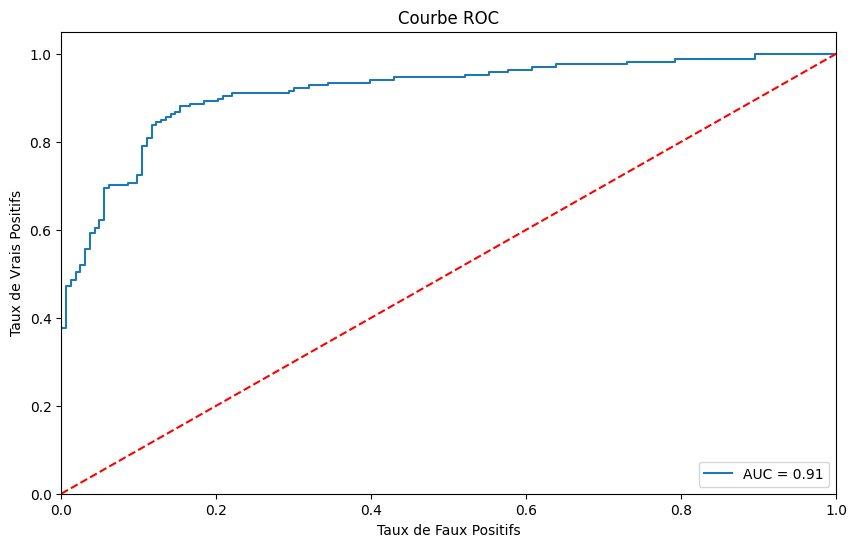

### Définition Score "métier"

*le coût d’un FN est dix fois supérieur au coût d’un FP*

## CE2 Vous avez choisi la ou les variables cibles pertinentes.

La variable cible est le "TARGET" 

## CE3 Vous avez vérifié qu'il n’y a pas de problème de data leakage (c'est-à-dire, des variables trop corrélées à la variable cible et inconnues a priori dans les données en entrée du modèle).

On utilisera les "features importances" pour vérifier si on n'a pas de data leakage

## CE4 Vous avez testé plusieurs algorithmes de façon cohérente, en partant des plus simples vers les plus complexes (au minimum un linéaire et un non linéaire).

Le dataset df contient des NaN:
- Linéaire -> Régression logistique (Obligé d'effectuer une imputation)
- Non Linéaire -> LightGBM (marche très bien pour un dataframe avec des NaN)
- Dummy -> dummyClassifier (Obligé d'effectuer une imputation)

# Évaluer les performances des modèles d’apprentissage supervisé selon différents critères (scores, temps d'entraînement, etc.) en adaptant les paramètres afin de choisir le modèle le plus performant pour la problématique métier.

## Déséquilibre entre le nombre de bons et de moins bons clients

Nombre de 0: 282682
Nombre de 1: 24825


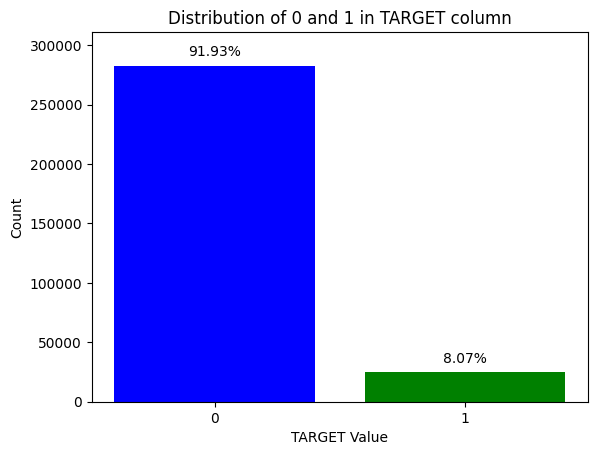

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Supposons que votre dataframe est déjà défini comme df

# Supprimer les NaN
df_clean = df['TARGET'].dropna()

# Compter le nombre de 0 et 1
count_0 = (df_clean == 0).sum()
count_1 = (df_clean == 1).sum()

# Créer les variables pour le nombre de 0 et 1
nb_0 = count_0
nb_1 = count_1

print(f"Nombre de 0: {nb_0}")
print(f"Nombre de 1: {nb_1}")

# Calculer les pourcentages
total = len(df_clean)
percentage_0 = (nb_0 / total) * 100
percentage_1 = (nb_1 / total) * 100

# Créer le graphique en barres
labels = ['0', '1']
values = [nb_0, nb_1]
bars = plt.bar(labels, values, color=['blue', 'green'])

# Augmenter l'espace en haut pour les annotations
plt.ylim(0, max(values) * 1.1)  # 10% d'espace supplémentaire en haut

# Annoter le graphique avec les pourcentages
for bar, pct in zip(bars, [percentage_0, percentage_1]):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, 
             height + 0.02 * max(values), 
             f'{pct:.2f}%', 
             ha='center', 
             va='bottom')

plt.xlabel('TARGET Value')
plt.ylabel('Count')
plt.title('Distribution of 0 and 1 in TARGET column')
plt.show()

On a énormément de 0 (plus de 91% du total), il va falloir en prendre en compte dans nos modèles

In [7]:
df_classification = df[df['TARGET'].notnull()]
df_classification.shape

(307507, 773)

**Création df_classification_imputed (stratégie: Moyenne)**

In [8]:
df_classification_imputed = df_classification.copy()
df_classification_imputed.fillna(df_classification.mean(), inplace=True)

## DummyClassifer

In [10]:
import mlflow
import mlflow.sklearn  # pour log le modèle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve
import gc
import time  # Pour mesurer le temps

# 1. Prétraiter les données
X = df_classification_imputed.drop(columns=["TARGET", "SK_ID_CURR"])
y = df_classification_imputed["TARGET"]

# 2. Préparer la Cross-Validation
cv = StratifiedKFold(n_splits=5)

# Hyperparamètres du DummyClassifier
strategies = ['stratified', 'most_frequent', 'prior', 'uniform', 'constant']

results = []

mlflow.set_experiment("DummyClassifier")

for strategy in strategies:
    with mlflow.start_run():
        dummy = DummyClassifier(strategy=strategy, constant=1 if strategy == 'constant' else None)

        # Mesurer le temps de traitement de fit
        start_time_fit = time.time()
        dummy.fit(X, y)
        elapsed_time_fit = time.time() - start_time_fit

        # Mesurer le temps de traitement de prédiction
        start_time_predict = time.time()
        y_prob = cross_val_predict(dummy, X, y, cv=cv, method="predict_proba")[:, 1]
        elapsed_time_predict = time.time() - start_time_predict
        
        y_pred = (y_prob > 0.5)

        # Calcul des scores
        auc = roc_auc_score(y, y_prob)
        acc = accuracy_score(y, y_pred)
        tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
        cost = fp + 10 * fn

        # Log les hyperparamètres, métriques et temps à MLflow
        mlflow.log_param("Strategy", strategy)
        mlflow.log_metric("AUC", auc)
        mlflow.log_metric("Accuracy", acc)
        mlflow.log_metric("Business Score", cost)
        mlflow.log_metric("Fit Time", elapsed_time_fit)
        mlflow.log_metric("Prediction Time", elapsed_time_predict)

        # Log le modèle à MLflow
        mlflow.sklearn.log_model(dummy, "dummy_model")

        # Stockage et log des courbes ROC
        fpr, tpr, thresholds = roc_curve(y, y_prob)
        
        plt.figure(figsize=(10, 7))
        plt.plot(fpr, tpr, label=f'AUC: {auc:.2f}')
        plt.title('ROC Curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.savefig("roc_curve.png")
        plt.close()
        mlflow.log_artifact("roc_curve.png")
        
        # Ajouter les résultats à la liste
        results.append({
            "Strategy": strategy,
            "AUC": auc,
            "Accuracy": acc,
            "Business Score": cost
        })

# Afficher les résultats
results_df = pd.DataFrame(results)

gc.collect()

777

In [16]:
styled_df_Dummy = results_df.sort_values(by='Business Score', ascending=True)

In [17]:
styled_df_Dummy .to_csv('results_Dummy.csv', index=False)

In [18]:
def highlight_max(s):
    '''
    Mettez en surbrillance la valeur maximale d'une série en vert.
    '''
    is_max = s == s.max()
    return ['background-color: green' if v else '' for v in is_max]

def highlight_min(s):
    '''
    Mettez en surbrillance la valeur minimale d'une série en vert.
    '''
    is_min = s == s.min()
    return ['background-color: green' if v else '' for v in is_min]

styled_df_Dummy  = (styled_df_Dummy.style.apply(highlight_max, subset=['AUC', 'Accuracy'])
                          .apply(highlight_min, subset=['Business Score'])
                          .format({'Threshold': "{:g}"}))

styled_df_Dummy

,Strategy,AUC,Accuracy,Business Score
1,most_frequent,0.500000,0.919270,248250
2,prior,0.499998,0.919270,248250
3,uniform,0.500000,0.919270,248250
0,stratified,0.500523,0.851460,250778
4,constant,0.500000,0.080730,282682


Le DummyClassifier génère des prédictions en fonction de sa stratégie, et non en fonction d'une probabilité qui varie avec le seuil

## Régression logistique

In [21]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve
from sklearn.preprocessing import StandardScaler
import gc
import time
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import optuna
import logging
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.simplefilter('ignore', ConvergenceWarning)
optuna_logger = logging.getLogger('optuna')
optuna_logger.setLevel(logging.CRITICAL)

start_time = time.time()

# Configuration initiale de MLflow
mlflow.set_experiment('Logistic_Regression')

nb_0 = (df_classification_imputed['TARGET'] == 0).sum()
nb_1 = (df_classification_imputed['TARGET'] == 1).sum()

X = df_classification_imputed.drop(columns=["TARGET", "SK_ID_CURR"])
y = df_classification_imputed["TARGET"]

scaler = StandardScaler()
X = scaler.fit_transform(X)

cv = StratifiedKFold(n_splits=5)
class_weights = {0: 1, 1: nb_0 / nb_1}

results = []

total_combinations = 50 

def objective(trial):
    C_val = trial.suggest_float('C_val', 50, 200)
    threshold = trial.suggest_float('threshold', 0.4, 0.6, step=0.01)

    model = LogisticRegression(C=C_val, class_weight=class_weights, verbose=0, max_iter=1000)
    
    # Enregistrement du temps de début pour le fit
    start_fit_time = time.time()
    y_prob = cross_val_predict(model, X, y, cv=cv, method="predict_proba")[:, 1]
    # Calculer le temps de fit
    fit_duration = time.time() - start_fit_time

    # Enregistrement du temps de début pour la prédiction
    start_pred_time = time.time()
    y_pred = y_prob > threshold
    # Calculer le temps de prédiction
    pred_duration = time.time() - start_pred_time

    auc = roc_auc_score(y, y_prob)
    acc = accuracy_score(y, y_pred)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    cost = fp + 10 * fn
    
    results.append({
        "C": C_val,
        "Threshold": threshold,
        "AUC": auc,
        "Accuracy": acc,
        "Business Score": cost
    })

    with mlflow.start_run():
        mlflow.log_param("C", C_val)
        mlflow.log_param("Threshold", round(threshold, 2))
        mlflow.log_metric("AUC", auc)
        mlflow.log_metric("Accuracy", acc)
        mlflow.log_metric("Business Score", cost)
        
        # Enregistrer les temps dans mlflow
        mlflow.log_metric("Fit Time", fit_duration)
        mlflow.log_metric("Prediction Time", pred_duration)

        fpr, tpr, _ = roc_curve(y, y_prob)
        plt.figure(figsize=(10, 7))
        plt.plot(fpr, tpr, label=f'AUC: {auc:.2f}')
        plt.title('ROC Curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.savefig("roc_curve.png")
        plt.close()
        mlflow.log_artifact("roc_curve.png")

        mlflow.sklearn.log_model(model, "model")
    
    gc.collect()

    return cost

def print_progress(study, trial, total_combinations):
    print(f"Essai {trial.number + 1}/{total_combinations} terminé!", end='\r', flush=True)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=total_combinations, callbacks=[lambda study, trial: print_progress(study, trial, total_combinations)])

results_df = pd.DataFrame(results)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nTemps écoulé: {elapsed_time:.2f} secondes")

print(study.best_params)

Essai 50/50 terminé!
Temps écoulé: 38825.94 secondes
{'C_val': 71.43846560856923, 'threshold': 0.52}


In [72]:
styled_df_Log_Reg = results_df.sort_values(by='Business Score', ascending=True)

In [41]:
styled_df_Log_Reg .to_csv('results_Log_Reg.csv', index=False)

In [81]:
def highlight_max(s):
    '''
    Mettez en surbrillance la valeur maximale d'une série en vert.
    '''
    is_max = s == s.max()
    return ['background-color: green' if v else '' for v in is_max]

def highlight_min(s):
    '''
    Mettez en surbrillance la valeur minimale d'une série en vert.
    '''
    is_min = s == s.min()
    return ['background-color: green' if v else '' for v in is_min]

styled_df_Log_Reg  = (styled_df_Log_Reg.style.apply(highlight_max, subset=['AUC', 'Accuracy'])
                          .apply(highlight_min, subset=['Business Score'])
                          .format({'Threshold': "{:g}", 'Business Score': "{:.0f}"}))

styled_df_Log_Reg 

,C,Threshold,AUC,Accuracy,Business Score
2,71.438466,0.52,0.772000,0.729222,156247
28,50.047366,0.52,0.772001,0.729268,156278
39,51.775567,0.52,0.771973,0.729213,156322
18,61.687971,0.52,0.771971,0.729261,156334
24,81.456258,0.52,0.771989,0.729216,156348
27,63.355949,0.52,0.771991,0.729213,156358
8,62.972821,0.52,0.771978,0.729258,156380
36,92.728319,0.52,0.771995,0.729128,156411
38,51.801737,0.52,0.772003,0.729206,156423
7,56.501559,0.52,0.771986,0.729216,156438


**On va plot les features importances:**

In [ ]:
study.best_params

**On va plot les features importances:**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

# Supposition que df_classification_imputed est déjà défini
nb_0 = len(df_classification_imputed[df_classification_imputed["TARGET"] == 0])
nb_1 = len(df_classification_imputed[df_classification_imputed["TARGET"] == 1])
class_weights = {0: 1, 1: nb_0 / nb_1}

X = df_classification_imputed.drop(columns=["TARGET", "SK_ID_CURR"])
y = df_classification_imputed["TARGET"]

# Stockage des noms des colonnes pour utilisation ultérieure
feature_names = X.columns

# Standardisation des données
scaler = StandardScaler()
X = scaler.fit_transform(X)  

# Remplacer 'C_val' par 'C'
params = study.best_params.copy()
params['C'] = params.pop('C_val')

# Suppression de 'threshold'
params.pop('threshold', None)

# Instanciation du modèle
clf = LogisticRegression(**params, class_weight=class_weights, max_iter=1000, verbose = 1)

# Validation croisée
cv = StratifiedKFold(n_splits=5)
feature_importances = np.zeros(X.shape[1])

for train, test in cv.split(X, y):
    clf.fit(X[train], y.iloc[train])
    # Pour la régression logistique, l'importance des caractéristiques est donnée par les coefficients
    feature_importances += np.abs(clf.coef_[0])

# Moyenne des importances de caractéristiques sur les plis
feature_importances /= 5

In [27]:
df_feature_importances_log_reg = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
})

df_feature_importances_log_reg = df_feature_importances_log_reg.sort_values(by='importance', ascending=False)
df_feature_importances_log_reg["importance"] = (df_feature_importances_log_reg["importance"]/ df_feature_importances_log_reg["importance"].sum())*100

In [28]:
df_feature_importances_log_reg.to_csv('df_feature_importances_log_reg.csv', index=False)

In [29]:
df_feature_importances_log_reg

,feature,importance
633,INSTAL_AMT_PAYMENT_SUM,5.929761
629,INSTAL_AMT_INSTALMENT_SUM,5.623575
621,INSTAL_PAYMENT_PERC_SUM,4.379378
619,INSTAL_PAYMENT_PERC_MAX,4.356888
755,CC_NAME_CONTRACT_STATUS_Demand_SUM,2.366382
735,CC_SK_DPD_DEF_MEAN,2.269398
736,CC_SK_DPD_DEF_SUM,2.053335
632,INSTAL_AMT_PAYMENT_MEAN,1.569664
628,INSTAL_AMT_INSTALMENT_MEAN,1.456832
754,CC_NAME_CONTRACT_STATUS_Demand_MEAN,1.445256


In [30]:
Pourcentage_importance_totale = 95

# Sort the dataframe by importance in descending order
df_sorted = df_feature_importances_log_reg.sort_values(by="importance", ascending=False)

# Calculate the cumulative importance
df_sorted["cumulative_importance"] = df_sorted["importance"].cumsum()

# Find the number of features needed to reach 99% of the total importance
num_features = df_sorted[df_sorted["cumulative_importance"] <= df_sorted["importance"].sum() * Pourcentage_importance_totale/100].shape[0]

num_features

400

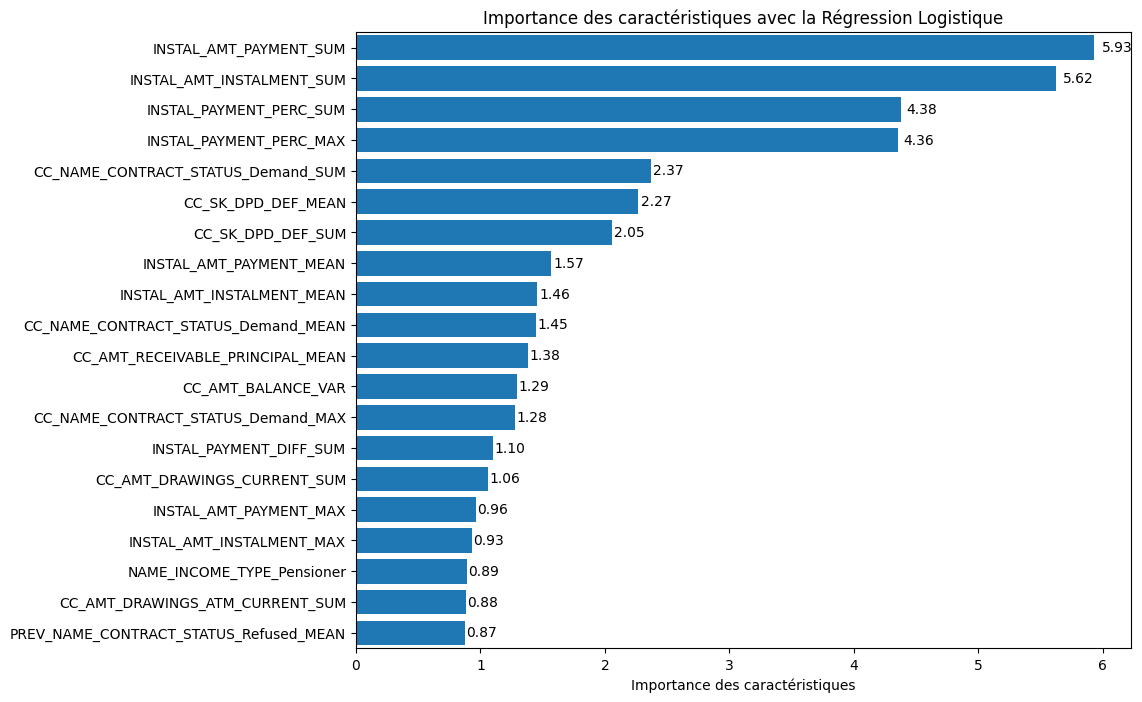

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Extraire les colonnes 'feature' et 'importance' de votre dataframe
features = df_feature_importances_log_reg['feature'].to_numpy()
importances = df_feature_importances_log_reg['importance'].to_numpy()

# Création d'un masque pour les importances supérieures à 0
mask = importances > 0

# Filtrage des features et des importances en utilisant le masque
filtered_feature_names = features[mask]
filtered_feature_importances = importances[mask]

# Supposons que vous vouliez afficher les 10 principales caractéristiques
n_features_to_display = 20

# Tri des indices filtrés par importance
sorted_idx = filtered_feature_importances.argsort()

# Limiter aux n principales caractéristiques
top_n_idx = sorted_idx[-n_features_to_display:]

# Affichage de l'importance des caractéristiques filtrées pour les n principales
plt.figure(figsize=(10, len(top_n_idx) * 0.4))
bars = plt.barh(filtered_feature_names[top_n_idx], filtered_feature_importances[top_n_idx])

# Ajuster les limites de l'axe des y pour réduire l'espace autour des barres
plt.ylim(-0.5, len(top_n_idx)-0.5)

plt.xlabel("Importance des caractéristiques")
plt.title("Importance des caractéristiques avec la Régression Logistique")

# Ajouter les valeurs à côté des barres
for bar in bars:
    width = bar.get_width()
    
    # Déterminez le formatage en fonction de la magnitude
    if width < 0.01:
        fmt = '{:.4f}'
    elif width < 0.1:
        fmt = '{:.3f}'
    else:
        fmt = '{:.2f}'
    
    plt.text(width + 0.01 * width,  # Ajouter un padding proportionnel à la valeur
             bar.get_y() + bar.get_height() / 2,
             fmt.format(width),
             va='center', ha='left')

plt.show()

Apparament, il n'y a pas de problème de data leaking car il n'y a pas de caractéristiques vraiment supérieures relatif aux autres

## LightGBM

L'avantage du LightGBM c'est qu'il marche bien avec des colonnes avec des NaN (on ne dénature pas le dataset avec une imputation)

In [33]:
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve
from sklearn.preprocessing import StandardScaler
import gc
import time
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import optuna
import logging

optuna_logger = logging.getLogger('optuna')
optuna_logger.setLevel(logging.CRITICAL)

start_time = time.time()

# Configuration initiale de MLflow
mlflow.set_experiment('LightGBM')

# Supposition : vous avez déjà votre dataframe 'df_classification' chargé
nb_0 = (df_classification['TARGET'] == 0).sum()
nb_1 = (df_classification['TARGET'] == 1).sum()

X = df_classification.drop(columns=["TARGET", "SK_ID_CURR"])
y = df_classification["TARGET"]

scaler = StandardScaler()
X = scaler.fit_transform(X)

cv = StratifiedKFold(n_splits=5)
class_weights = {0: 1, 1: nb_0 / nb_1}

results = []

total_combinations = 50  # définissez cela avant d'appeler study.optimize()

def objective(trial):
    lr = trial.suggest_float('lr', 0.001, 0.1, log=True)
    num_leaves = trial.suggest_int('num_leaves', 31, 70)
    n_estimators = trial.suggest_int('n_estimators', 100, 1000, log=True)
    threshold = trial.suggest_float('threshold', 0.4, 0.6, step=0.01)

    model = LGBMClassifier(learning_rate=lr, num_leaves=num_leaves, n_estimators=n_estimators, class_weight=class_weights, verbose=-1)
    
    # Enregistrement du temps de début pour le fit
    start_fit_time = time.time()
    y_prob = cross_val_predict(model, X, y, cv=cv, method="predict_proba")[:, 1]
    # Calculer le temps de fit
    fit_duration = time.time() - start_fit_time

    # Enregistrement du temps de début pour la prédiction
    start_pred_time = time.time()
    y_pred = y_prob > threshold
    # Calculer le temps de prédiction
    pred_duration = time.time() - start_pred_time

    auc = roc_auc_score(y, y_prob)
    acc = accuracy_score(y, y_pred)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    cost = fp + 10 * fn
    
    results.append({
        "Learning Rate": lr,
        "Num Leaves": num_leaves,
        "Threshold": threshold,
        "AUC": auc,
        "Accuracy": acc,
        "Business Score": cost
    })

    with mlflow.start_run():
        mlflow.log_param("Learning Rate", lr)
        mlflow.log_param("Num Leaves", num_leaves)
        mlflow.log_param("N Estimators", n_estimators) 
        mlflow.log_param("Threshold", round(threshold, 2))
        mlflow.log_metric("AUC", auc)
        mlflow.log_metric("Accuracy", acc)
        mlflow.log_metric("Business Score", cost)
        
        # Enregistrer les temps dans mlflow
        mlflow.log_metric("Fit Time", fit_duration)
        mlflow.log_metric("Prediction Time", pred_duration)

        fpr, tpr, _ = roc_curve(y, y_prob)
        plt.figure(figsize=(10, 7))
        plt.plot(fpr, tpr, label=f'AUC: {auc:.2f}')
        plt.title('ROC Curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.savefig("roc_curve.png")
        plt.close()
        mlflow.log_artifact("roc_curve.png")

        mlflow.sklearn.log_model(model, "model")
    
    gc.collect()

    return cost

def print_progress(study, trial, total_combinations):
    print(f"Essai {trial.number + 1}/{total_combinations} terminé!", end='\r', flush=True)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=total_combinations, callbacks=[lambda study, trial: print_progress(study, trial, total_combinations)])

# 6. Afficher les résultats
results_df = pd.DataFrame(results)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nTemps écoulé: {elapsed_time:.2f} secondes")

print(study.best_params)

Essai 50/50 terminé!
Temps écoulé: 19353.58 secondes
{'lr': 0.016914256489425572, 'num_leaves': 55, 'n_estimators': 672, 'threshold': 0.48000000000000004}


In [82]:
styled_df_LGM = results_df.sort_values(by='Business Score', ascending=True)

In [83]:
styled_df_LGM.to_csv('results_LGM.csv', index=False)

In [84]:
def highlight_max(s):
    '''
    Mettez en surbrillance la valeur maximale d'une série en vert.
    '''
    is_max = s == s.max()
    return ['background-color: green' if v else '' for v in is_max]

def highlight_min(s):
    '''
    Mettez en surbrillance la valeur minimale d'une série en vert.
    '''
    is_min = s == s.min()
    return ['background-color: green' if v else '' for v in is_min]

styled_df_LGM = (styled_df_LGM.style.apply(highlight_max, subset=['AUC', 'Accuracy'])
                          .apply(highlight_min, subset=['Business Score'])
                          .format({'Threshold': "{:g}"}))

styled_df_LGM

,Learning Rate,Num Leaves,Threshold,AUC,Accuracy,Business Score
49,0.016914,55,0.48,0.787351,0.736048,149513
43,0.026320,50,0.48,0.787115,0.733775,149753
47,0.019547,50,0.48,0.787132,0.729307,149759
44,0.021350,50,0.48,0.786871,0.727889,149808
42,0.028617,45,0.49,0.786997,0.738985,149933
41,0.032140,45,0.49,0.787091,0.741918,150003
38,0.044664,46,0.49,0.786588,0.755046,150070
40,0.030554,45,0.49,0.787141,0.740279,150138
48,0.024486,49,0.51,0.787357,0.765706,150176
39,0.029883,46,0.49,0.786859,0.740995,150260


**On va plot les features importances:**

In [85]:
study.best_params

{'lr': 0.016914256489425572,
 'num_leaves': 55,
 'n_estimators': 672,
 'threshold': 0.48000000000000004}

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

# Supposition que df_classification_imputed est déjà défini
nb_0 = len(df_classification[df_classification["TARGET"] == 0])
nb_1 = len(df_classification[df_classification["TARGET"] == 1])
class_weights = {0: 1, 1: nb_0 / nb_1}

X = df_classification.drop(columns=["TARGET", "SK_ID_CURR"])
y = df_classification["TARGET"]

# Stockage des noms des colonnes pour utilisation ultérieure
feature_names = X.columns

# Standardisation des données
scaler = StandardScaler()
X = scaler.fit_transform(X)  

# Instanciation du modèle
clf = LGBMClassifier(**study.best_params, class_weight=class_weights, verbose=1)

# Validation croisée
cv = StratifiedKFold(n_splits=5)
feature_importances = np.zeros(X.shape[1])

for train, test in cv.split(X, y):
    clf.fit(X[train], y.iloc[train])
    feature_importances += clf.feature_importances_

# Moyenne des importances de caractéristiques sur les plis
feature_importances /= 5

[LightGBM] [Warning] Unknown parameter: lr
[LightGBM] [Warning] Unknown parameter: threshold
[LightGBM] [Warning] Unknown parameter: lr
[LightGBM] [Warning] Unknown parameter: threshold
[LightGBM] [Info] Number of positive: 19860, number of negative: 226145
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.625006 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 100670
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500001 -> initscore=0.000003
[LightGBM] [Info] Start training from score 0.000003
[LightGBM] [Warning] Unknown parameter: lr
[LightGBM] [Warning] Unknown parameter: threshold
[LightGBM] [Warning] Unknown parameter: lr
[LightGBM] [Warning] Unknown parameter: threshold
[LightGBM] [Info] Number of positive: 19860, number of negative: 226145
[LightGBM] [Warning] Auto-choosing col-wise multi-thread

In [87]:
df_feature_importances_lightGBM = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
})

df_feature_importances_lightGBM = df_feature_importances_lightGBM.sort_values(by='importance', ascending=False)
df_feature_importances_lightGBM["importance"] = (df_feature_importances_lightGBM["importance"]/ df_feature_importances_lightGBM["importance"].sum())*100

In [88]:
df_feature_importances_lightGBM.to_csv('df_feature_importances_lightGBM.csv', index=False)

In [89]:
df_feature_importances_lightGBM

,feature,importance
28,EXT_SOURCE_2,1.559744
29,EXT_SOURCE_3,1.548170
27,EXT_SOURCE_1,1.371803
247,PAYMENT_RATE,1.344797
6,DAYS_BIRTH,1.091270
7,DAYS_EMPLOYED,0.983796
9,DAYS_ID_PUBLISH,0.941358
8,DAYS_REGISTRATION,0.911596
3,AMT_ANNUITY,0.900022
243,DAYS_EMPLOYED_PERC,0.885141


In [90]:
Pourcentage_importance_totale = 95

# Sort the dataframe by importance in descending order
df_sorted = df_feature_importances_lightGBM.sort_values(by="importance", ascending=False)

# Calculate the cumulative importance
df_sorted["cumulative_importance"] = df_sorted["importance"].cumsum()

# Find the number of features needed to reach 99% of the total importance
num_features = df_sorted[df_sorted["cumulative_importance"] <= df_sorted["importance"].sum() * Pourcentage_importance_totale/100].shape[0]

num_features

396

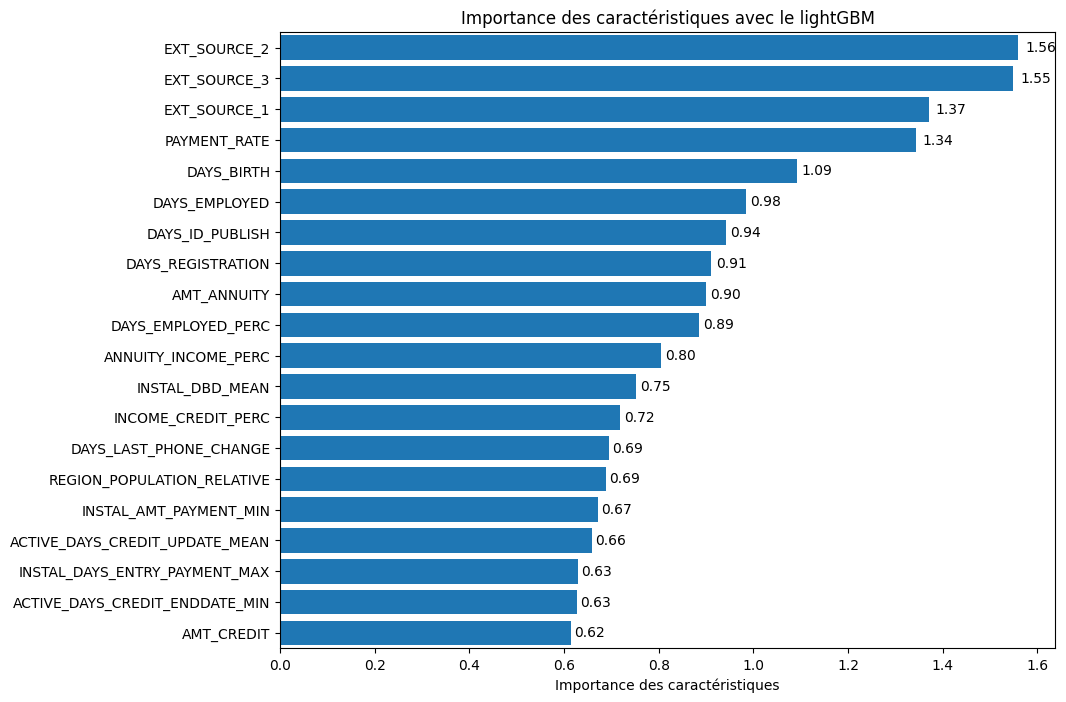

In [91]:
import numpy as np
import matplotlib.pyplot as plt

# Extraire les colonnes 'feature' et 'importance' de votre dataframe
features = df_feature_importances_lightGBM['feature'].to_numpy()
importances = df_feature_importances_lightGBM['importance'].to_numpy()

# Création d'un masque pour les importances supérieures à 0
mask = importances > 0

# Filtrage des features et des importances en utilisant le masque
filtered_feature_names = features[mask]
filtered_feature_importances = importances[mask]

# Supposons que vous vouliez afficher les 10 principales caractéristiques
n_features_to_display = 20

# Tri des indices filtrés par importance
sorted_idx = filtered_feature_importances.argsort()

# Limiter aux n principales caractéristiques
top_n_idx = sorted_idx[-n_features_to_display:]

# Affichage de l'importance des caractéristiques filtrées pour les n principales
plt.figure(figsize=(10, len(top_n_idx) * 0.4))
bars = plt.barh(filtered_feature_names[top_n_idx], filtered_feature_importances[top_n_idx])

# Ajuster les limites de l'axe des y pour réduire l'espace autour des barres
plt.ylim(-0.5, len(top_n_idx)-0.5)

plt.xlabel("Importance des caractéristiques")
plt.title("Importance des caractéristiques avec le lightGBM")

# Ajouter les valeurs à côté des barres
for bar in bars:
    width = bar.get_width()
    
    # Déterminez le formatage en fonction de la magnitude
    if width < 0.01:
        fmt = '{:.4f}'
    elif width < 0.1:
        fmt = '{:.3f}'
    else:
        fmt = '{:.2f}'
    
    plt.text(width + 0.01 * width,  # Ajouter un padding proportionnel à la valeur
             bar.get_y() + bar.get_height() / 2,
             fmt.format(width),
             va='center', ha='left')

plt.show()

Apparament, il n'y a pas de problème de data leaking car il n'y a pas de caractéristiques vraiment supérieures relatif aux autres

In [92]:
gc.collect()

181662

# Analyse data drift

In [3]:
application_train = df.dropna(subset=['TARGET']).drop(columns=['SK_ID_CURR','TARGET'])

application_test = df[df['TARGET'].isna()].drop(columns=['SK_ID_CURR','TARGET'])

In [4]:
application_train = application_train.sample(frac=0.1)
application_test = application_test.sample(frac=0.1)

In [5]:
print(application_train.shape)
application_train.head()

(30751, 771)


,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_B

In [6]:
print(application_test.shape)
application_test.head()

(4874, 771)


,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_B

Pour les colonnes catégorielles on va ne prendre que les colonnes ayant que des 0 et des 1 

In [6]:
import numpy as np

# Liste pour stocker les colonnes qui ne contiennent que des 0, 1 et potentiellement NaN
categorical_columns = []

# Parcourir chaque colonne
for col in application_train.columns:
    # Récupérer les valeurs uniques de la colonne
    unique_vals = set(application_train[col].unique())
    
    # Vérifier si les valeurs uniques sont uniquement 0, 1, et potentiellement NaN
    if unique_vals.issubset({0, 1, np.nan}):
        categorical_columns.append(col)

In [7]:
# Afficher les colonnes qui ne contiennent que des 0 et des 1
print(len(categorical_columns))
application_train[categorical_columns].head(5)

171


,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: 

In [8]:
numerical_columns = [col for col in application_train.columns if col not in categorical_columns]

In [9]:
print(len(categorical_columns) + len(numerical_columns))

771


In [11]:
try:
    import evidently
except ImportError:
    !pip install git+https://github.com/evidentlyai/evidently.git

import time 
import pandas as pd
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset
from evidently import ColumnMapping

start_time = time.time()

# Vérifiez que vos deux DataFrames ont exactement les mêmes colonnes
assert set(application_train.columns) == set(application_test.columns)

# Si l'assertion est réussie, cela signifie que les colonnes correspondent
print("Les colonnes correspondent!")

# Création du column mapping
column_mapping = ColumnMapping()

column_mapping.numerical_features = numerical_columns
column_mapping.categorical_features = categorical_columns

# Créer le rapport de dérive des données
data_drift_report = Report(metrics=[
    DataDriftPreset(num_stattest='ks', cat_stattest='psi', num_stattest_threshold=0.2, cat_stattest_threshold=0.2),
])

print("Création du data_drift_report")

data_drift_report.run(reference_data=application_train, current_data=application_test, column_mapping=column_mapping)

print("Run du data_drift_report")

elapsed_time_fit = time.time() - start_time
elapsed_time_fit

Les colonnes correspondent!
Création du data_drift_report
Run du data_drift_report


30255.67957663536

In [39]:
# Sauvegardez le rapport en tant que fichier HTML
data_drift_report.save_html('data_drift_report.html')